This notebook validates CCL with CAMB

In [1]:
import sys, platform, os
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import pyccl as ccl
plt.style.use("seaborn-notebook")

#Assume installed from github using "git clone --recursive https://github.com/cmbant/CAMB.git"
#This file is then in the docs folders
camb_path = os.path.realpath(os.path.join(os.getcwd(),'..'))
sys.path.insert(0,camb_path)
import camb
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

Using CAMB 1.1.3 installed at /home/tanveer/anaconda3/lib/python3.7/site-packages/camb


In [2]:
ell = np.arange(0, 1501, 1)
lmin = 100
lmax = 1501
fs = 15

In [3]:
#Set up a new set of parameters for CAMB
pars = camb.CAMBparams()

pars.set_cosmology(H0=67.0, ombh2=0.02216, omch2=0.1203, mnu=0.06, tau=0.06)
pars.InitPower.set_params(As=2.119e-9, ns=0.964)
pars.set_for_lmax(1500, lens_potential_accuracy=1);

#calculate results for these parameters
results = camb.get_results(pars)
cl_camb = results.get_lens_potential_cls(lmax=1500)

Text(0.5, 1.0, 'CMB Lensing from CAMB')

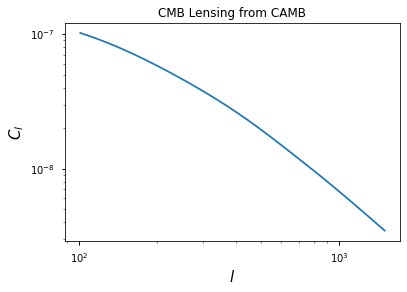

In [4]:
plt.loglog(ell[ell > lmin], cl_camb[:,0][ell > lmin])
plt.ylabel(r"$C_l$", fontsize = fs)
plt.xlabel(r"$l$", fontsize = fs)
plt.title("CMB Lensing from CAMB")

In [5]:
#calculate C_ls from CCL

cosmo = ccl.Cosmology(Omega_c = 0.268, Omega_b = 0.04937,
        h = 0.670, n_s = 0.964, A_s = 2.119e-9, 
        m_nu_type='list', m_nu = np.array([0, 0, 0.06]),
        transfer_function='boltzmann_camb') 

cmbl = ccl.CMBLensingTracer(cosmo, z_source=1090.)
cl_ccl = ccl.angular_cl(cosmo, cmbl, cmbl, ell)

/home/tanveer/anaconda3/lib/python3.7/site-packages/pyccl/core.py:678: CCLWarning: CCL does not properly compute the linear growth rate in cosmological models with massive neutrinos!
  category=CCLWarning)


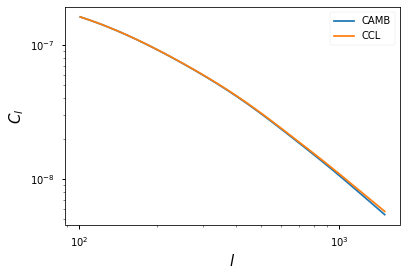

In [6]:
#CAMB needs a pi/2 prefactor

plt.loglog(ell[ell > lmin], (np.pi/2) * cl_camb[:,0][ell > lmin], label = 'CAMB')
plt.loglog(ell[ell > lmin], cl_ccl[ell > lmin], label = 'CCL')
plt.ylabel(r"$C_l$", fontsize = fs)
plt.xlabel(r"$l$", fontsize = fs)
plt.legend(loc = 'best')

Note: CAMB and CCL are off? 

In [7]:
#Import Planck reconstructed noise and signal

nlkk = np.genfromtxt("data/MV/nlkk.dat")
ell_planck = nlkk[:,0]
N_l = nlkk[:,1]
C_lplusN_l = nlkk[:,2]

/home/tanveer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
No handles with labels found to put in legend.


Text(0.5, 1.0, 'CCL')

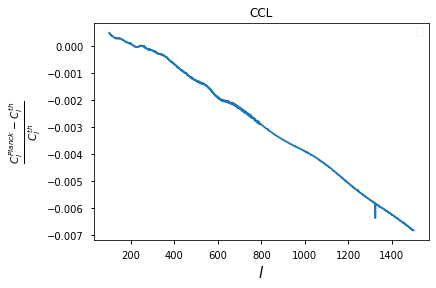

In [8]:
plt.plot(ell[ell > lmin], ((C_lplusN_l - N_l)[ell_planck < lmax]/cl_ccl- 1)[ell > lmin])
plt.ylabel(r"$\frac{C^{Planck}_{l} - C^{th}_{l}}{C^{th}_{l}}$", fontsize = fs)
plt.xlabel(r'$l$', fontsize = fs)
plt.legend(loc = 'best')
plt.title("CCL")

/home/tanveer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/tanveer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'CAMB')

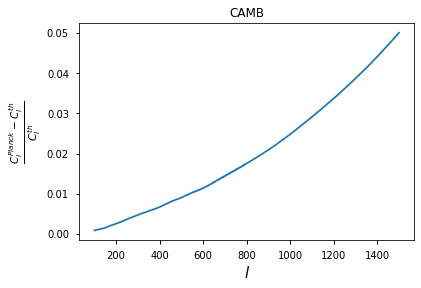

In [9]:
plt.plot(ell[ell > lmin], ((C_lplusN_l - N_l)[ell_planck < lmax]/(np.pi/2 * cl_camb[:,0]) - 1)[ell > lmin])
plt.ylabel(r"$\frac{C^{Planck}_{l} - C^{th}_{l}}{C^{th}_{l}}$", fontsize = fs)
plt.xlabel(r'$l$', fontsize = fs)
plt.title("CAMB")

### Generating P(k) using CCL and then comparing C(l) code with CCL 

Set cosmology

In [2]:
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, A_s=2.1e-9, n_s=0.96, 
                      transfer_function='boltzmann_camb')

Set params

In [3]:
kmin, kmax, nk = 1e-4, 1e1, 128
k = np.logspace(np.log10(kmin), np.log10(kmax), nk) # Wavenumber
a = 1. # Scale factor a z=0
a_arr = np.linspace(0.1,1,128)

Calculate linear and non-linear power spectra

In [4]:
pk_lin = ccl.linear_matter_power(cosmo, k, a)
pk_nl = ccl.nonlin_matter_power(cosmo, k, a)

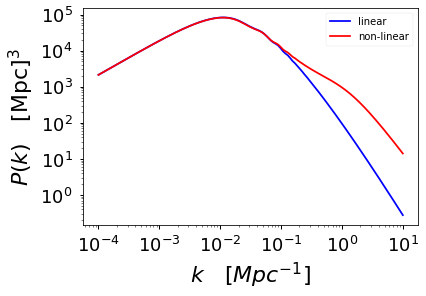

In [5]:
plt.plot(k, pk_lin, 'b-', label = 'linear')
plt.plot(k, pk_nl, 'r-', label = 'non-linear')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('$k\quad[Mpc^{-1}]$', fontsize = 22)
plt.ylabel('$P(k)\quad[{\\rm Mpc}]^3$', fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc = 'best')
plt.show()

Set redshift range and $n(z)$

Text(0, 0.5, 'n(z)')

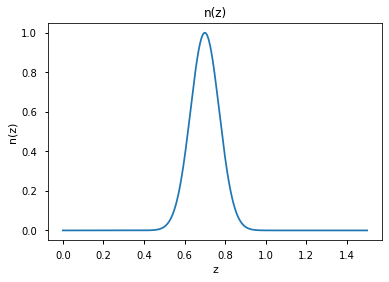

In [6]:
z = np.linspace(0, 1.5, 1024)
nz = np.exp(-((z-0.7)/0.1)**2)

plt.plot(z, nz)
plt.title('n(z)')
plt.xlabel('z')
plt.ylabel('n(z)')

Generate number counts tracer object and set bias to $1$ since we are trying to generate $C^{\kappa \kappa}_{l}$

In [7]:
t_g = ccl.NumberCountsTracer(cosmo, has_rsd = False, dndz=(z, nz), bias=(z, np.ones_like(z)))

Calculate $C_l$s 

In [8]:
ell = np.unique(np.geomspace(2,1000,100).astype(int)).astype(float)
cls_gg = ccl.angular_cl(cosmo, t_g, t_g, ell)

No handles with labels found to put in legend.


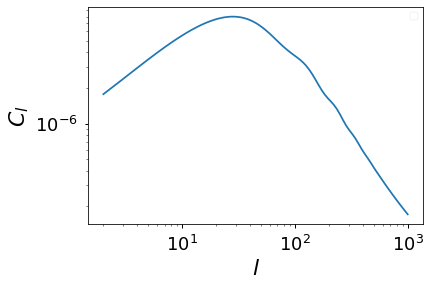

In [10]:
plt.plot(ell, cls_gg)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$l$', fontsize = 22)
plt.ylabel('$C_{l}$', fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc = 'best')
plt.show()

In [32]:
import camb
from camb import model, initialpower

#import pyccl
#from classy import Class
import numpy as np
from scipy.interpolate import interp1d
from astropy.cosmology import Planck15 as cosmo
from astropy.constants import c,G
from astropy import units as u
from scipy.integrate import quad as scipy_int1d

cosmo_h=cosmo.clone(H0=100)
c=c.to(u.km/u.second)

cosmo_fid=dict({'h':cosmo.h,'Omb':cosmo.Ob0,'Omd':cosmo.Om0-cosmo.Ob0,'s8':0.817,'Om':cosmo.Om0,
                'As':2.12e-09,'mnu':cosmo.m_nu[-1].value,'Omk':cosmo.Ok0,'tau':0.06,'ns':0.965,'w':-1,'wa':0})
pk_params={'non_linear':1,'kmax':30,'kmin':3.e-4,'nk':5000}
class_accuracy_settings={ #from Vanessa. To avoid class errors due to compiler issues.
                          #https://github.com/lesgourg/class_public/issues/193
            "k_min_tau0":0.002, #you could try change this
            "k_max_tau0_over_l_max":3., #you can also try 5 here
            "k_step_sub":0.015,
            "k_step_super":0.0001,
            "k_step_super_reduction":0.1,
            'k_per_decade_for_pk': 20,
#             'k_output_values': 2.0,
            'perturb_sampling_stepsize':0.01,
            'tol_perturb_integration':1.e-4,
            'halofit_k_per_decade': 3000. #you could try change this
            }
class Power_Spectra():
    def __init__(self,cosmo_params=cosmo_fid,pk_params=pk_params,cosmo=cosmo,cosmo_h=None):
        self.cosmo_params=cosmo_params
        self.pk_params=pk_params
        self.cosmo=cosmo

        if not cosmo_h:
            self.cosmo_h=cosmo.clone(H0=100)
        else:
            self.cosmo_h=cosmo_h
            
        if not pk_params is None:
            self.kh=np.logspace(np.log10(pk_params['kmin']),np.log10(pk_params['kmax']),
            pk_params['nk'])

    def Rho_crit(self,cosmo_h=None):
        if not cosmo_h:
            cosmo_h=self.cosmo_h
        G2=G.to(u.Mpc/u.Msun*u.km**2/u.second**2)
        rc=3*cosmo_h.H0**2/(8*np.pi*G2)
        rc=rc.to(u.Msun/u.pc**2/u.Mpc)# unit of Msun/pc^2/mpc
        return rc

    def DZ_int(self,z=[0],cosmo=None): #linear growth factor.. full integral.. eq 63 in Lahav and suto
        if not cosmo:
            cosmo=self.cosmo
        def intf(z):
            return (1+z)/(cosmo.H(z).value)**3
        j=0
        Dz=np.zeros_like(z,dtype='float32')
        
        for i in z:
            Dz[j]=cosmo.H(i).value*scipy_int1d(intf,i,np.inf,epsrel=1.e-6,epsabs=1.e-6)[0]
            j=j+1
        Dz*=(2.5*cosmo.Om0*cosmo.H0.value**2)
        return Dz/Dz[0]

    def sigma_crit(self,zl=[],zs=[],cosmo_h=None):
        if not cosmo_h:
            cosmo_h=self.cosmo_h
        ds=cosmo_h.comoving_transverse_distance(zs)
        dl=cosmo_h.comoving_transverse_distance(zl)
        ddls=1-np.multiply.outer(1./ds,dl)#(ds-dl)/ds
        w=(3./2.)*((cosmo_h.H0/c)**2)*(1+zl)*dl/self.Rho_crit(cosmo_h)
        sigma_c=1./(ddls*w)
        x=ddls<=0 #zs<zl
        sigma_c[x]=np.inf
        return sigma_c

    def sigma_crit_inv(self,zl=[],zs=[],cosmo_h=None):
        rho=self.Rho_crit(cosmo_h=cosmo_h)*cosmo_h.Om0
        return rho/self.sigma_crit(zl=zl,zs=zs,cosmo_h=cosmo_h)

    def ccl_pk(self,z,cosmo_params=None,pk_params=None):
        if not cosmo_params:
            cosmo_params=self.cosmo_params
        if not pk_params:
            pk_params=self.pk_params

        cosmo_ccl=pyccl.Cosmology(h=cosmo_params['h'],Omega_c=cosmo_params['Omd'],Omega_b=cosmo_params['Omb'],
                              A_s=cosmo_params['As'],n_s=cosmo_params['ns'],m_nu=cosmo_params['mnu'])
        kh=np.logspace(np.log10(pk_params['kmin']),np.log10(pk_params['kmax']),pk_params['nk'])
        nz=len(z)
        ps=np.zeros((nz,pk_params['nk']))
        ps0=[]
        z0=9.#PS(z0) will be rescaled using growth function when CCL fails. 

        pyccl_pkf=pyccl.linear_matter_power
        if pk_params['non_linear']==1:
            pyccl_pkf=pyccl.nonlin_matter_power
        for i in np.arange(nz):
            try:
                ps[i]= pyccl_pkf(cosmo_ccl,kh,1./(1+z[i]))
            except Exception as err:
                print ('CCL err',err,z[i])
                if not np.any(ps0):
                    ps0=pyccl.linear_matter_power(cosmo_ccl,kh,1./(1.+z0))
                Dz=self.DZ_int(z=[z0,z[i]])
                ps[i]=ps0*(Dz[1]/Dz[0])**2
        return ps*cosmo_params['h']**3,kh/cosmo_params['h'] #factors of h to get in same units as camb output

    def camb_pk(self,z,cosmo_params=None,pk_params=None,return_s8=False):
        #Set up a new set of parameters for CAMB
        if not cosmo_params:
            cosmo_params=self.cosmo_params
        if not pk_params:
            pk_params=self.pk_params

        pars = camb.CAMBparams()
        h=cosmo_params['h']

        pars.set_cosmology(H0=h*100,
                            ombh2=cosmo_params['Omb']*h**2,
                            omch2=(cosmo_params['Om']-cosmo_params['Omb'])*h**2,
                            mnu=cosmo_params['mnu'],tau=cosmo_params['tau']
                            ) #    omk=cosmo_params['Omk'], )

        #stdout=np.copy(sys.stdout)
        #sys.stdout = open(os.devnull, 'w')

        pars.InitPower.set_params(ns=cosmo_params['ns'], r=0,As =cosmo_params['As']) #
        if return_s8:
            z_t=np.sort(np.unique(np.append([0],z).flatten()))
        else:
            z_t=np.array(z)
        pars.set_matter_power(redshifts=z_t,kmax=pk_params['kmax'])

        #sys.stdout = sys.__stdout__
        #sys.stdout=stdout

        if pk_params['non_linear']==1:
            pars.NonLinear = model.NonLinear_both
        else:
            pars.NonLinear = model.NonLinear_none

        results = camb.get_results(pars) #This is the time consuming part.. pk add little more (~5%).. others are negligible.

        kh, z2, pk =results.get_matter_power_spectrum(minkh=pk_params['kmin'],
                                                        maxkh=pk_params['kmax'],
                                                        npoints =pk_params['nk'])
        if not np.all(z2==z_t):
            raise Exception('CAMB changed z order',z2,z_mocks)

        if return_s8:
            s8=results.get_sigma8()
            if len(s8)>len(z):
                return pk[1:],kh,s8[-1]
            else:
                return pk,kh,s8[-1]
        else:
            return pk,kh

    def camb_pk_too_many_z(self,z,cosmo_params=None,pk_params=None):
        i=0
        pk=np.array([])
        z_step=140 #camb cannot handle more than 150 redshifts
        nz=len(z)
        while pk.shape[0]<nz:
            pki,kh=self.camb_pk(z=z[i:i+z_step],pk_params=pk_params,cosmo_params=cosmo_params,return_s8=False)
            pk=np.vstack((pk,pki)) if pk.size else pki
            i+=z_step
        return pk,kh
    
    def class_pk(self,z,cosmo_params=None,pk_params=None,return_s8=False):
       #Class may crash for z>9
        if  cosmo_params is None:
            cosmo_params=self.cosmo_params
        if pk_params is None:
            pk_params=self.pk_params
            
        cosmoC=Class()
        h=cosmo_params['h']
        class_params={'h':h,'omega_b':cosmo_params['Omb']*h**2,
                            'omega_cdm':(cosmo_params['Om']-cosmo_params['Omb'])*h**2,
                            'A_s':cosmo_params['As'],'n_s':cosmo_params['ns'],
                            'output': 'mPk','z_max_pk':100, #max(z)*2, #to avoid class error.
                                      #Allegedly a compiler error, whatever that means
                            'P_k_max_1/Mpc':pk_params['kmax']*h*1.1,
                    }
        if pk_params['non_linear']==1:
            class_params['non linear']='halofit'

        class_params['N_ur']=3.04 #ultra relativistic species... neutrinos
        if cosmo_params['mnu']!=0:
            class_params['N_ur']-=1 #one massive neutrino
            class_params['m_ncdm']=cosmo_params['mnu']
        class_params['N_ncdm']=3.04-class_params['N_ur']
        if cosmo_params['w']!=-1 or cosmo_params['wa']!=0:
            class_params['Omega_fld']=cosmo_params['Oml']
            class_params['w0_fld']=cosmo_params['w']
            class_params['wa_fld']=cosmo_params['wa']

        for ke in class_accuracy_settings.keys():
            class_params[ke]=class_accuracy_settings[ke]

        cosmoC=Class()
        cosmoC.set(class_params)
        try:
            cosmoC.compute()
        except Exception as err:
            print(class_params, err)
            raise Exception('Class crashed')

        k=self.kh*h
        pkC=np.array([[cosmoC.pk(ki,zj) for ki in k ]for zj in z])
        pkC*=h**3
        s8=cosmoC.sigma8()
        cosmoC.struct_cleanup()
        if return_s8:
            return pkC,self.kh,s8
        else:
            return pkC,self.kh
    
    def cl_z(self,z=[],l=np.arange(2000)+1,pk_params=None,cosmo_h=None,cosmo=None,pk_func=None):
        if not cosmo_h:
            cosmo_h=self.cosmo_h
        if not pk_func:
            #pk_func=self.camb_pk_too_many_z
            #pk_func=self.class_pk
            print("ok")

        nz=len(z)
        nl=len(l)

        pk,kh=pk_func(z=z,pk_params=pk_params)

        cls=np.zeros((nz,nl),dtype='float32')*u.Mpc**2
        for i in np.arange(nz):
            DC_i=cosmo_h.comoving_transverse_distance(z[i]).value#because camb k in h/mpc
            lz=kh*DC_i-0.5
            DC_i=cosmo_h.comoving_transverse_distance(z[i]).value
            pk_int=interp1d(lz,pk[i]/DC_i**2,bounds_error=False,fill_value=0)
            cls[i][:]+=pk_int(l)*u.Mpc*(c/(cosmo_h.efunc(z[i])*cosmo_h.H0))
        return cls

    def kappa_cl(self,zl_min=0,zl_max=1100,n_zl=10,log_zl=False,pk_func=None,
                zs1=[1100],p_zs1=[1],zs2=[1100],p_zs2=[1],
                pk_params=None,cosmo_h=None,l=np.arange(2,2001)):
        if not cosmo_h:
            cosmo_h=self.cosmo_h

        if log_zl:#bins for z_lens. 
            zl=np.logspace(np.log10(max(zl_min,1.e-4)),np.log10(zl_max),n_zl)
        else:
            zl=np.linspace(zl_min,zl_max,n_zl)

        clz=self.cl_z(z=zl,l=l,cosmo_h=cosmo_h,pk_params=pk_params,pk_func=pk_func)

        rho=self.Rho_crit(cosmo_h=cosmo_h)*cosmo_h.Om0
        kernel1=self.sigma_crit_inv
        kernel2=self.sigma_crit_inv
        sigma_c1=kernel1(zl=zl,zs=zs1,cosmo_h=cosmo_h)
        sigma_c2=kernel2(zl=zl,zs=zs2,cosmo_h=cosmo_h)
        #sigma_c1=rho/self.sigma_crit(zl=zl,zs=zs1,cosmo_h=cosmo_h)
        #sigma_c2=rho/self.sigma_crit(zl=zl,zs=zs2,cosmo_h=cosmo_h)

        dzl=np.gradient(zl)
        dzs1=np.gradient(zs1) if len(zs1)>1 else 1
        dzs2=np.gradient(zs2) if len(zs2)>1 else 1

        cl_zs_12=np.einsum('ji,ki,il',sigma_c2,sigma_c1*dzl,clz)#integrate over zl..
        cl=np.dot(p_zs2*dzs2,np.dot(p_zs1*dzs1,cl_zs_12))
        cl/=np.sum(p_zs2*dzs2)*np.sum(p_zs1*dzs1)
        f=(l+0.5)**2/(l*(l+1.)) #correction from Kilbinger+ 2017
        cl/=f**2
        #cl*=2./np.pi #comparison with CAMB requires this.
        return l,cl


if __name__ == "__main__":
    PS=Power_Spectra()
    l,cl=PS.kappa_cl(n_zl=140,log_zl=True,zl_min=1.e-4,zl_max=5) #camb
#    l,cl2=PS.kappa_cl(n_zl=140,log_zl=True,zl_min=1.e-4,zl_max=1100,pk_func=PS.ccl_pk)
    fname='kappa_cl_cmb'
    np.savetxt(fname+'_camb.dat',np.column_stack((l,cl)))
    #np.savetxt(fname+'_ccl.dat',np.column_stack((l,cl2)))

ok


TypeError: 'NoneType' object is not callable